Time stepping: 100%|██████████| 1080/1080 [01:16<00:00, 14.20it/s]


Price at (x=100, y=100) = 9695.8296


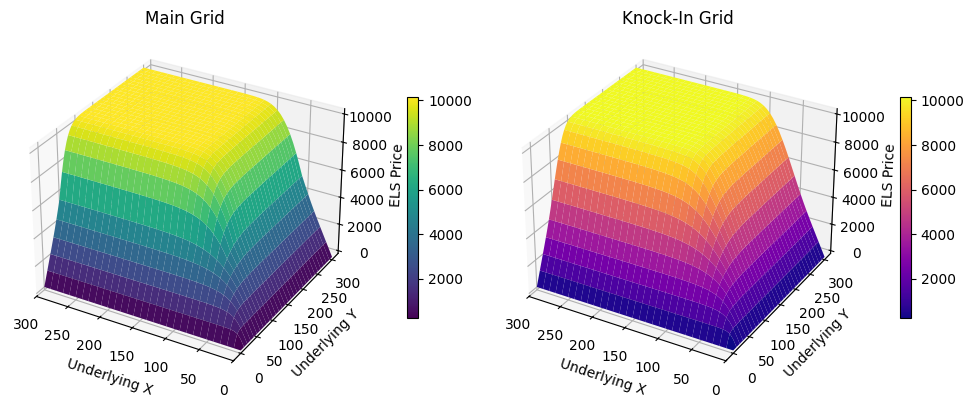

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def thomas_solver(lower_diag, main_diag, upper_diag, rhs):
    """
    Thomas 알고리즘(3중 대각행렬)으로 Ax = rhs 풀기.

    lower_diag: 하부 대각 (길이 n)
    main_diag : 메인 대각 (길이 n)
    upper_diag: 상부 대각 (길이 n)
    rhs       : 우변 벡터 (길이 n)
    """
    n = len(rhs)
    x = np.zeros(n, dtype=float)

    # 복사본 만들어서 작업
    a = lower_diag.copy()
    b = main_diag.copy()
    c = upper_diag.copy()
    f = rhs.copy()

    # (1) Forward Elimination
    for i in range(1, n):
        m = a[i] / b[i - 1]
        b[i] -= m * c[i - 1]
        f[i] -= m * f[i - 1]

    # (2) Back Substitution
    x[n - 1] = f[n - 1] / b[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = (f[i] - c[i] * x[i + 1]) / b[i]

    return x

def update_in_x_direction(old_grid, new_grid,
                          nx, ny, dt, h,
                          x_values, y_values,
                          sigma_x, sigma_y, r, rho):
    """
    ADI 1단계: x-방향 묵근(Implicit)
    (j 고정, i방향 3중대각 선형계 풀이)
    각 j 반복마다 경계조건을 즉시 갱신.
    """
    # i=1..nx-2 구간에 대한 3중 대각 계수
    lower_x = -0.5 * (sigma_x * x_values[1:nx-1] / h)**2 + 0.5 * r * (x_values[1:nx-1] / h)
    diag_x  = 1/dt + (sigma_x * x_values[1:nx-1] / h)**2 + 0.5 * r
    upper_x = -0.5 * (sigma_x * x_values[1:nx-1] / h)**2 - 0.5 * r * (x_values[1:nx-1] / h)

    # 원본 코드처럼 마지막 계수 보정
    lower_x[-1] -= upper_x[-1]
    diag_x[-1]  += 2 * upper_x[-1]

    rhs_x = np.zeros(nx - 2)

    for j in range(1, ny - 1):
        # 우변 (rhs) 계산: 묵근 항 + 교차미분 항
        rhs_x[:] = old_grid[1:nx - 1, j] / dt

        cross_coef = 0.5 * rho * sigma_x * sigma_y * x_values[1:nx - 1] * y_values[j]
        for i in range(1, nx - 1):
            rhs_x[i - 1] += cross_coef[i - 1] * (
                old_grid[i + 1, j + 1] - old_grid[i + 1, j - 1]
                - old_grid[i - 1, j + 1] + old_grid[i - 1, j - 1]
            ) / (4 * h * h)

        sol_slice = thomas_solver(lower_x, diag_x, upper_x, rhs_x)
        new_grid[1:nx - 1, j] = sol_slice

        # **즉시 경계 업데이트** (원본처럼 각 j 반복마다)
        new_grid[nx - 1, 1:ny - 1] = 2 * new_grid[nx - 2, 1:ny - 1] - new_grid[nx - 3, 1:ny - 1]
        new_grid[:, ny - 1] = 2 * new_grid[:, ny - 2] - new_grid[:, ny - 3]

def update_in_y_direction(old_grid, new_grid,
                          nx, ny, dt, h,
                          x_values, y_values,
                          sigma_x, sigma_y, r, rho):
    """
    ADI 2단계: y-방향 묵근(Implicit)
    (i 고정, j방향 3중대각 선형계 풀이)
    각 i 반복마다 경계조건을 즉시 갱신.
    """
    lower_y = -0.5 * (sigma_y * y_values[1:ny-1] / h)**2 + 0.5 * r * (y_values[1:ny-1] / h)
    diag_y  = 1/dt + (sigma_y * y_values[1:ny-1] / h)**2 + 0.5 * r
    upper_y = -0.5 * (sigma_y * y_values[1:ny-1] / h)**2 - 0.5 * r * (y_values[1:ny-1] / h)

    lower_y[-1] -= upper_y[-1]
    diag_y[-1]  += 2 * upper_y[-1]

    rhs_y = np.zeros(ny - 2)

    for i in range(1, nx - 1):
        rhs_y[:] = old_grid[i, 1:ny - 1] / dt

        cross_coef = 0.5 * rho * sigma_x * sigma_y * x_values[i] * y_values[1:ny - 1]
        for j in range(1, ny - 1):
            rhs_y[j - 1] += cross_coef[j - 1] * (
                old_grid[i + 1, j + 1] - old_grid[i + 1, j - 1]
                - old_grid[i - 1, j + 1] + old_grid[i - 1, j - 1]
            ) / (4 * h * h)

        sol_slice = thomas_solver(lower_y, diag_y, upper_y, rhs_y)
        new_grid[i, 1:ny - 1] = sol_slice

        # **즉시 경계 업데이트** (원본처럼 각 i 반복마다)
        new_grid[1:nx - 1, ny - 1] = 2 * new_grid[1:nx - 1, ny - 2] - new_grid[1:nx - 1, ny - 3]
        new_grid[nx - 1, :] = 2 * new_grid[nx - 2, :] - new_grid[nx - 3, :]

def main_els_pricing():
    # ----------------------
    # 1) 파라미터 설정
    # ----------------------
    FACE_VALUE = 10000
    R = 300
    SIGMA_X = 0.249
    SIGMA_Y = 0.2182
    RHO = 0.0981
    RISK_FREE = 0.0165

    num_x = 61
    num_y = num_x
    x_points = np.linspace(0, R, num_x)
    y_points = np.linspace(0, R, num_y)
    h = R / num_x  # 원본처럼 h = R / num_x

    T = 3
    Nt = 360 * T   # 1080 스텝
    dt = T / Nt

    # 쿠폰율 및 이벤트 스텝(조기상환 시점)
    coupon_rate = np.array([0.15, 0.125, 0.10, 0.075, 0.05, 0.025])
    step_events = np.array([
        int(round(Nt/6)),
        int(round(2*Nt/6)),
        int(round(3*Nt/6)),
        int(round(4*Nt/6)),
        int(round(5*Nt/6)),
        Nt + 1
    ])

    # 초기 조건 관련
    strike_array = np.array([0.75, 0.80, 0.85, 0.85, 0.90, 0.90])
    dummy_coupon = 0.15
    KIB = 0.50

    # ----------------------
    # 2) 격자 준비
    # ----------------------
    main_grid = np.zeros((num_x, num_y))
    knock_grid = np.zeros((num_x, num_y))

    X0 = 100
    Y0 = 100

    # (A) 만기(또는 첫 스텝)에서의 Payoff 세팅
    for i in range(num_x):
        for j in range(num_y):
            if (x_points[i] < KIB * X0) or (y_points[j] < KIB * Y0):
                payoff_val = min(x_points[i], y_points[j]) / X0 * FACE_VALUE
                main_grid[i, j] = payoff_val
                knock_grid[i, j] = payoff_val
            elif (x_points[i] <= strike_array[0] * X0) or (y_points[j] <= strike_array[0] * Y0):
                main_grid[i, j] = FACE_VALUE * (1 + dummy_coupon)
                knock_grid[i, j] = min(x_points[i], y_points[j]) / X0 * FACE_VALUE
            else:
                main_grid[i, j] = FACE_VALUE * (1 + coupon_rate[0])
                knock_grid[i, j] = FACE_VALUE * (1 + coupon_rate[0])

    # ----------------------
    # 3) 시간 스텝(ADI) + 진행상황(tqdm)
    # ----------------------
    tag = 0

    for n in tqdm(range(Nt), desc="Time stepping"):
        # (a) 이벤트(조기상환 시점) 체크
        if n == step_events[tag]:
            if tag < len(coupon_rate) - 1:
                boundary_x = np.min(np.where(x_points >= X0 * strike_array[tag+1]))
                boundary_y = np.min(np.where(y_points >= Y0 * strike_array[tag+1]))
                main_grid[boundary_x:num_x, boundary_y:num_y] = FACE_VALUE * (1 + coupon_rate[tag+1])
                knock_grid[boundary_x:num_x, boundary_y:num_y] = FACE_VALUE * (1 + coupon_rate[tag+1])
            tag += 1

        # (b) Knock-In Barrier 적용
        boundary_kib_x = np.min(np.where(x_points >= X0 * KIB))
        boundary_kib_y = np.min(np.where(y_points >= Y0 * KIB))
        main_grid[:boundary_kib_x+1, :] = knock_grid[:boundary_kib_x+1, :]
        main_grid[:, :boundary_kib_y+1] = knock_grid[:, :boundary_kib_y+1]

        # (c) ADI 스텝: main_grid
        old_main = main_grid.copy()
        update_in_x_direction(old_main, main_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO)
        old_main = main_grid.copy()
        update_in_y_direction(old_main, main_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO)

        # (d) ADI 스텝: knock_grid
        old_knock = knock_grid.copy()
        update_in_x_direction(old_knock, knock_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO)
        old_knock = knock_grid.copy()
        update_in_y_direction(old_knock, knock_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO)

    # ----------------------
    # 4) 결과 시각화 + 숫자 출력
    # ----------------------
    X_mesh, Y_mesh = np.meshgrid(x_points, y_points, indexing='ij')

    fig = plt.figure(figsize=(10, 4))

    # (왼쪽) main_grid 플롯 후
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X_mesh, Y_mesh, main_grid, cmap='viridis', edgecolor='none')
    ax1.set_xlabel("Underlying X")
    ax1.set_ylabel("Underlying Y")
    ax1.set_zlabel("ELS Price")
    ax1.set_title("Main Grid")
    fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1)

    # x축 범위 반대로 설정 (방법 1)
    ax1.set_xlim(R, 0)
    # 또는 ax1.invert_xaxis()

    # (오른쪽) knock_grid 플롯 후
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X_mesh, Y_mesh, knock_grid, cmap='plasma', edgecolor='none')
    ax2.set_xlabel("Underlying X")
    ax2.set_ylabel("Underlying Y")
    ax2.set_zlabel("ELS Price")
    ax2.set_title("Knock-In Grid")
    fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1)

    # x축 범위 반대로 설정 (방법 1)
    ax2.set_xlim(R, 0)
    # 또는 ax2.invert_xaxis()

    idx_x = np.where(x_points == 100)[0][0]
    idx_y = np.where(y_points == 100)[0][0]
    price_100_100 = main_grid[idx_x, idx_y]
    print("Price at (x=100, y=100) = {:.4f}".format(price_100_100))

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main_els_pricing()
